In [39]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
import matplotlib.pyplot as plt

In [40]:
data=[[1, 2], [3, 4]]

In [41]:
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

In [42]:
x_data.size()

torch.Size([2, 2])

In [43]:
w = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

#input
x = torch.tensor([3.0])

In [44]:
# Forward pass
y_pred = w * x + b
print(f"y_pred : {y_pred.item()}")

y_pred : 7.0


In [45]:
#Loss
y_true = torch.tensor([10.0])
loss = (y_pred - y_true)**2
print(f"loss : {loss.item()}")

loss : 9.0


In [46]:
print(f"w grad before backward: {w.grad}")

w grad before backward: None


In [47]:
loss.backward()

In [48]:
print(f"w grad after backward: {w.grad}")

w grad after backward: tensor([-18.])


In [49]:
learning_rate = 0.01
with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

In [50]:
print(f"nouveaux poids w: {w}, b: {b}")

nouveaux poids w: tensor([2.1800], requires_grad=True), b: tensor([1.0600], requires_grad=True)


In [51]:
w.grad.zero_()
b.grad.zero_()
print(f"w grad after zeroing: {w.grad}")
print(f"b grad after zeroing: {b.grad}")

w grad after zeroing: tensor([0.])
b grad after zeroing: tensor([0.])


In [52]:
import torch.nn as nn

perceptron = nn.Linear(1, 1)

In [53]:
x = torch.tensor([3.0])
print(f"input x: {x}")
y_pred = perceptron(x)
print(f"prediction after weight update y_pred: {y_pred}")

input x: tensor([3.])
prediction after weight update y_pred: tensor([0.4011], grad_fn=<ViewBackward0>)


In [54]:
y_true = torch.tensor([10.0])
criterion = torch.nn.MSELoss()
loss = criterion(y_pred, y_true)

In [55]:
loss.backward()
print(f"gradient du poids: {perceptron.weight.grad}")
print(f"gradient du biais: {perceptron.bias.grad}")

gradient du poids: tensor([[-57.5932]])
gradient du biais: tensor([-19.1977])


In [56]:
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.01)
x_train = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
y_train = torch.tensor([[3.0], [5.0], [7.0], [9.0]])

# for epoch in range(20):
#     for x, y in zip(x_train, y_train):
#         y_pred = perceptron(x)
#         loss = criterion(y_pred, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [57]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl = nn.Linear(2, 4)
        self.fcl2 = nn.Linear(4, 3)
        self.fcl3 = nn.Linear(3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fcl(x)
        x = self.relu(x)
        x = self.fcl2(x)
        x = self.relu(x)
        x = self.fcl3(x)
        x = self.sigmoid(x)
        return x

In [58]:
model = SimpleNet()
print(model)

SimpleNet(
  (fcl): Linear(in_features=2, out_features=4, bias=True)
  (fcl2): Linear(in_features=4, out_features=3, bias=True)
  (fcl3): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [59]:
x = torch.tensor([1.0, 2.0])
y = torch.tensor([5.0])
y_pred = model(x)
print(f"y_pred: {y_pred}")

y_pred: tensor([0.5037], grad_fn=<SigmoidBackward0>)


In [60]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [61]:

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=64, pin_memory=True, num_workers=4)

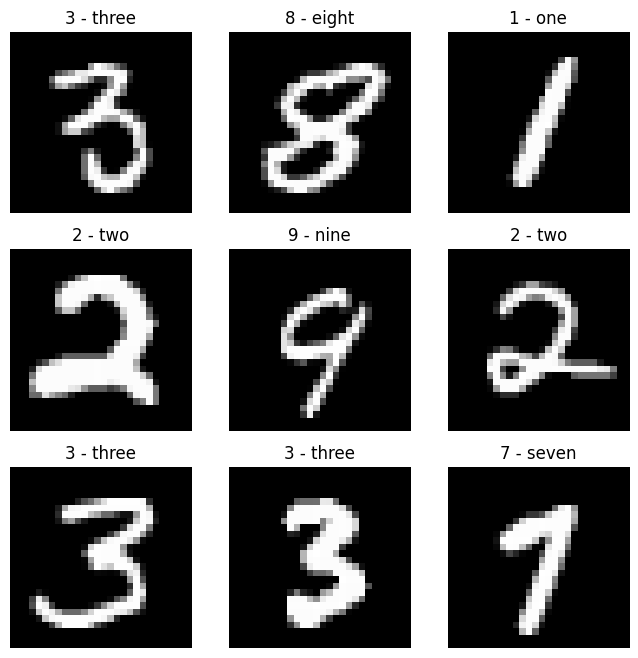

In [62]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(training_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

In [63]:
print(training_data.classes)
print(training_data.data.size)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
<built-in method size of Tensor object at 0x00000276E28862D0>


In [64]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

In [65]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [66]:
x = torch.randn(1, 28, 28, device=device)
logits = model(x)
print(logits)

tensor([[ 0.0934,  0.1759, -0.0298, -0.1454, -0.0811,  0.1751,  0.1533, -0.0903,
          0.0576, -0.0227]], grad_fn=<AddmmBackward0>)


In [67]:
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)

tensor([[0.1060, 0.1151, 0.0937, 0.0835, 0.0890, 0.1151, 0.1126, 0.0882, 0.1023,
         0.0944]], grad_fn=<SoftmaxBackward0>)


In [68]:
y_pred = pred_probab.argmax(1)
print(y_pred)

tensor([1])


In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [70]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for id, value in enumerate(dataloader):
        X, y = value
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if id % 100 == 0:
            loss, current = loss.item(), (id + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5}]")

In [71]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("done")

Epoch 1
-------------------------------


c:\IIM-SCHOOL\A4\ia1\cours\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


loss: 2.295672  [   64/60000]
loss: 0.315399  [ 6464/60000]
loss: 0.315399  [ 6464/60000]
loss: 0.120502  [12864/60000]
loss: 0.120502  [12864/60000]
loss: 0.169696  [19264/60000]
loss: 0.169696  [19264/60000]
loss: 0.469306  [25664/60000]
loss: 0.469306  [25664/60000]
loss: 0.245375  [32064/60000]
loss: 0.245375  [32064/60000]
loss: 0.125109  [38464/60000]
loss: 0.125109  [38464/60000]
loss: 0.092906  [44864/60000]
loss: 0.092906  [44864/60000]
loss: 0.272183  [51264/60000]
loss: 0.272183  [51264/60000]
loss: 0.022666  [57664/60000]
loss: 0.022666  [57664/60000]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.114366 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.114366 

Epoch 2
-------------------------------
loss: 0.126297  [   64/60000]
loss: 0.126297  [   64/60000]
loss: 0.064783  [ 6464/60000]
loss: 0.064783  [ 6464/60000]
loss: 0.061460  [12864/60000]
loss: 0.061460  [12864/60000]
loss: 0.134384  [19264/60000]
loss: 0.134384  [19264/60000]
loss: 

In [73]:
example_inputs = (torch.randn(1, 1, 28, 28),)
model.to("cpu")
onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)
onnx_program.save("image_classifier_model.onnx")

[torch.onnx] Obtain model graph for `NeuralNetwork([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `NeuralNetwork([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Obtain model graph for `NeuralNetwork([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [74]:
class ModelWithSoftmax(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        logits = self.model(x)
        return self.softmax(logits)

model_with_softmax = ModelWithSoftmax(model)
model_with_softmax.eval()

dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(
    model_with_softmax,
    dummy_input,
    "model_with_softmax.onnx",
    input_names=['input'],
    output_names=['probabilities']
)

[torch.onnx] Obtain model graph for `ModelWithSoftmax([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ModelWithSoftmax([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.1+cpu',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,1,28,28]>
            ),
            outputs=(
                %"probabilities"<FLOAT,[1,10]>
            ),
            initializers=(
                %"model.fc.0.weight"<FLOAT,[512,784]>{TorchTensor(...)},
                %"model.fc.0.bias"<FLOAT,[512]>{TorchTensor(...)},
                %"model.fc.2.weight"<FLOAT,[128,512]>{TorchTensor(...)},
                %"model.fc.2.bias"<FLOAT,[128]>{TorchTensor(...)},
                %"model.fc.4.weight"<FLOAT,[10,128]>{TorchTensor(...)},
                %"model.fc.4.bias"<FLOAT,[10]>{TorchTensor<FLOAT,[10]>(Parameter containing: tensor([ 0.0067, -0.0315, -0.0824, -0.1292, -0.0313,  0.0545, -0.0183, -0.154

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torchmetrics

In [76]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root="data/", download=True, train=True, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root="data/", download=True, train=False, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

writer = SummaryWriter('runs/mnist_experiment_1')

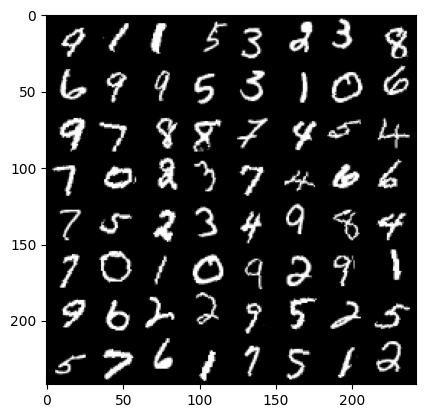

In [77]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
imshow(torchvision.utils.make_grid(images))


In [78]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):

        """
        Building blocks of convolutional neural network.
        Parameters:
            * in_channels: Number of channels in the input image (for grayscale images, 1)
            * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(16 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        x = F.relu(x)              # Apply ReLU activation
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # Apply second fully connected layer
        x = F.relu(x)              # Apply ReLU activation
        x = self.dropout(x)        # Apply dropout
        x = self.fc3(x)            # Apply output layer
        return x

In [79]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=10).to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [80]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [81]:
# Get one batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Log the model graph
writer.add_graph(model, images)

In [82]:
num_epochs=10
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_index % 100 == 99:
            print(f"  Step [{batch_index + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
            writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + batch_index)
            running_loss = 0.0
writer.close()

Epoch [1/10]


 11%|█         | 103/938 [00:03<00:27, 29.83it/s]

  Step [100/938], Loss: 1.7037


 22%|██▏       | 205/938 [00:05<00:18, 38.80it/s]

  Step [200/938], Loss: 0.8563


 32%|███▏      | 303/938 [00:08<00:15, 41.40it/s]

  Step [300/938], Loss: 0.5277


 43%|████▎     | 403/938 [00:10<00:12, 41.96it/s]

  Step [400/938], Loss: 0.3822


 54%|█████▎    | 502/938 [00:13<00:10, 40.45it/s]

  Step [500/938], Loss: 0.3290


 65%|██████▍   | 606/938 [00:15<00:07, 41.53it/s]

  Step [600/938], Loss: 0.2651


 75%|███████▌  | 706/938 [00:18<00:05, 40.75it/s]

  Step [700/938], Loss: 0.2564


 86%|████████▌ | 805/938 [00:20<00:03, 39.80it/s]

  Step [800/938], Loss: 0.2311


 96%|█████████▋| 905/938 [00:22<00:00, 41.78it/s]

  Step [900/938], Loss: 0.2115


100%|██████████| 938/938 [00:23<00:00, 39.64it/s]


Epoch [2/10]


 11%|█         | 105/938 [00:02<00:20, 40.38it/s]

  Step [100/938], Loss: 0.2015


 22%|██▏       | 205/938 [00:05<00:18, 40.58it/s]

  Step [200/938], Loss: 0.1847


 33%|███▎      | 306/938 [00:07<00:15, 40.77it/s]

  Step [300/938], Loss: 0.1732


 43%|████▎     | 407/938 [00:10<00:12, 41.61it/s]

  Step [400/938], Loss: 0.1809


 54%|█████▍    | 507/938 [00:12<00:10, 40.97it/s]

  Step [500/938], Loss: 0.1609


 65%|██████▍   | 607/938 [00:15<00:08, 40.42it/s]

  Step [600/938], Loss: 0.1480


 75%|███████▌  | 705/938 [00:17<00:05, 40.95it/s]

  Step [700/938], Loss: 0.1496


 86%|████████▌ | 805/938 [00:19<00:03, 41.22it/s]

  Step [800/938], Loss: 0.1456


 96%|█████████▋| 903/938 [00:22<00:00, 39.83it/s]

  Step [900/938], Loss: 0.1559


100%|██████████| 938/938 [00:23<00:00, 40.42it/s]


Epoch [3/10]


 11%|█         | 104/938 [00:02<00:20, 40.62it/s]

  Step [100/938], Loss: 0.1356


 22%|██▏       | 204/938 [00:05<00:18, 40.06it/s]

  Step [200/938], Loss: 0.1276


 32%|███▏      | 304/938 [00:07<00:15, 40.43it/s]

  Step [300/938], Loss: 0.1326


 43%|████▎     | 404/938 [00:09<00:13, 40.82it/s]

  Step [400/938], Loss: 0.1323


 54%|█████▍    | 507/938 [00:12<00:10, 40.33it/s]

  Step [500/938], Loss: 0.1173


 65%|██████▍   | 606/938 [00:14<00:08, 39.82it/s]

  Step [600/938], Loss: 0.1239


 75%|███████▌  | 704/938 [00:17<00:06, 39.00it/s]

  Step [700/938], Loss: 0.1221


 86%|████████▌ | 806/938 [00:19<00:03, 41.54it/s]

  Step [800/938], Loss: 0.1260


 97%|█████████▋| 906/938 [00:22<00:00, 40.13it/s]

  Step [900/938], Loss: 0.1118


100%|██████████| 938/938 [00:23<00:00, 40.77it/s]


Epoch [4/10]


 11%|█         | 105/938 [00:02<00:20, 40.73it/s]

  Step [100/938], Loss: 0.1054


 22%|██▏       | 205/938 [00:04<00:17, 41.47it/s]

  Step [200/938], Loss: 0.1084


 32%|███▏      | 304/938 [00:07<00:16, 38.15it/s]

  Step [300/938], Loss: 0.1026


 43%|████▎     | 407/938 [00:09<00:12, 41.67it/s]

  Step [400/938], Loss: 0.1024


 54%|█████▍    | 507/938 [00:12<00:10, 41.68it/s]

  Step [500/938], Loss: 0.1198


 65%|██████▍   | 607/938 [00:14<00:07, 41.64it/s]

  Step [600/938], Loss: 0.0979


 75%|███████▌  | 706/938 [00:17<00:05, 41.17it/s]

  Step [700/938], Loss: 0.1130


 86%|████████▌ | 806/938 [00:19<00:03, 39.51it/s]

  Step [800/938], Loss: 0.1060


 97%|█████████▋| 906/938 [00:22<00:00, 39.65it/s]

  Step [900/938], Loss: 0.0989


100%|██████████| 938/938 [00:22<00:00, 41.03it/s]


Epoch [5/10]


 11%|█         | 105/938 [00:02<00:20, 40.24it/s]

  Step [100/938], Loss: 0.0919


 22%|██▏       | 205/938 [00:04<00:17, 41.72it/s]

  Step [200/938], Loss: 0.0940


 33%|███▎      | 305/938 [00:07<00:15, 41.18it/s]

  Step [300/938], Loss: 0.1091


 43%|████▎     | 403/938 [00:09<00:13, 41.13it/s]

  Step [400/938], Loss: 0.0967


 54%|█████▎    | 503/938 [00:12<00:10, 39.69it/s]

  Step [500/938], Loss: 0.0910


 65%|██████▍   | 607/938 [00:14<00:07, 42.00it/s]

  Step [600/938], Loss: 0.0920


 75%|███████▍  | 702/938 [00:17<00:05, 40.81it/s]

  Step [700/938], Loss: 0.1016


 86%|████████▌ | 806/938 [00:19<00:03, 41.24it/s]

  Step [800/938], Loss: 0.0907


 97%|█████████▋| 906/938 [00:21<00:00, 40.94it/s]

  Step [900/938], Loss: 0.0798


100%|██████████| 938/938 [00:22<00:00, 41.27it/s]


Epoch [6/10]


 11%|█         | 103/938 [00:02<00:19, 42.25it/s]

  Step [100/938], Loss: 0.0954


 22%|██▏       | 207/938 [00:05<00:18, 40.29it/s]

  Step [200/938], Loss: 0.0803


 33%|███▎      | 307/938 [00:07<00:15, 40.90it/s]

  Step [300/938], Loss: 0.0958


 43%|████▎     | 406/938 [00:09<00:13, 38.65it/s]

  Step [400/938], Loss: 0.0946


 54%|█████▍    | 506/938 [00:12<00:10, 41.59it/s]

  Step [500/938], Loss: 0.0714


 65%|██████▍   | 606/938 [00:14<00:08, 40.90it/s]

  Step [600/938], Loss: 0.0913


 75%|███████▌  | 707/938 [00:17<00:05, 40.74it/s]

  Step [700/938], Loss: 0.0855


 86%|████████▌ | 807/938 [00:19<00:03, 41.58it/s]

  Step [800/938], Loss: 0.0862


 97%|█████████▋| 907/938 [00:22<00:00, 41.01it/s]

  Step [900/938], Loss: 0.0849


100%|██████████| 938/938 [00:22<00:00, 40.85it/s]


Epoch [7/10]


 11%|█         | 105/938 [00:02<00:20, 40.50it/s]

  Step [100/938], Loss: 0.0776


 22%|██▏       | 205/938 [00:04<00:17, 41.18it/s]

  Step [200/938], Loss: 0.0733


 33%|███▎      | 305/938 [00:07<00:15, 41.40it/s]

  Step [300/938], Loss: 0.0822


 43%|████▎     | 405/938 [00:09<00:12, 41.66it/s]

  Step [400/938], Loss: 0.0712


 54%|█████▎    | 503/938 [00:12<00:10, 41.04it/s]

  Step [500/938], Loss: 0.0807


 64%|██████▍   | 605/938 [00:14<00:08, 39.31it/s]

  Step [600/938], Loss: 0.0857


 75%|███████▌  | 705/938 [00:17<00:05, 41.03it/s]

  Step [700/938], Loss: 0.0782


 86%|████████▌ | 805/938 [00:19<00:03, 40.47it/s]

  Step [800/938], Loss: 0.0789


 96%|█████████▋| 904/938 [00:22<00:00, 41.99it/s]

  Step [900/938], Loss: 0.0881


100%|██████████| 938/938 [00:22<00:00, 40.82it/s]


Epoch [8/10]


 11%|█         | 105/938 [00:02<00:22, 37.16it/s]

  Step [100/938], Loss: 0.0753


 22%|██▏       | 207/938 [00:05<00:17, 41.02it/s]

  Step [200/938], Loss: 0.0726


 33%|███▎      | 307/938 [00:07<00:15, 40.91it/s]

  Step [300/938], Loss: 0.0719


 43%|████▎     | 407/938 [00:09<00:12, 41.14it/s]

  Step [400/938], Loss: 0.0726


 54%|█████▍    | 507/938 [00:12<00:10, 40.77it/s]

  Step [500/938], Loss: 0.0781


 64%|██████▍   | 603/938 [00:14<00:08, 40.40it/s]

  Step [600/938], Loss: 0.0734


 75%|███████▍  | 703/938 [00:17<00:05, 41.64it/s]

  Step [700/938], Loss: 0.0870


 86%|████████▌ | 807/938 [00:19<00:03, 40.86it/s]

  Step [800/938], Loss: 0.0747


 97%|█████████▋| 907/938 [00:22<00:00, 40.81it/s]

  Step [900/938], Loss: 0.0856


100%|██████████| 938/938 [00:22<00:00, 40.98it/s]


Epoch [9/10]


 11%|█         | 105/938 [00:02<00:21, 38.61it/s]

  Step [100/938], Loss: 0.0706


 22%|██▏       | 205/938 [00:05<00:19, 38.02it/s]

  Step [200/938], Loss: 0.0738


 32%|███▏      | 304/938 [00:08<00:18, 34.89it/s]

  Step [300/938], Loss: 0.0768


 43%|████▎     | 402/938 [00:10<00:14, 36.07it/s]

  Step [400/938], Loss: 0.0715


 54%|█████▍    | 506/938 [00:13<00:11, 36.95it/s]

  Step [500/938], Loss: 0.0772


 64%|██████▍   | 602/938 [00:16<00:08, 40.18it/s]

  Step [600/938], Loss: 0.0645


 75%|███████▌  | 704/938 [00:18<00:05, 40.07it/s]

  Step [700/938], Loss: 0.0797


 86%|████████▌ | 804/938 [00:21<00:03, 40.40it/s]

  Step [800/938], Loss: 0.0662


 96%|█████████▋| 904/938 [00:23<00:00, 40.50it/s]

  Step [900/938], Loss: 0.0718


100%|██████████| 938/938 [00:24<00:00, 38.23it/s]


Epoch [10/10]


 11%|█▏        | 107/938 [00:02<00:21, 39.20it/s]

  Step [100/938], Loss: 0.0699


 22%|██▏       | 203/938 [00:05<00:18, 39.36it/s]

  Step [200/938], Loss: 0.0709


 33%|███▎      | 306/938 [00:07<00:16, 37.60it/s]

  Step [300/938], Loss: 0.0734


 43%|████▎     | 404/938 [00:10<00:13, 40.04it/s]

  Step [400/938], Loss: 0.0789


 54%|█████▎    | 504/938 [00:13<00:11, 37.79it/s]

  Step [500/938], Loss: 0.0697


 64%|██████▍   | 604/938 [00:15<00:08, 37.72it/s]

  Step [600/938], Loss: 0.0649


 75%|███████▌  | 704/938 [00:18<00:05, 39.99it/s]

  Step [700/938], Loss: 0.0659


 86%|████████▌ | 805/938 [00:20<00:03, 40.86it/s]

  Step [800/938], Loss: 0.0707


 96%|█████████▋| 905/938 [00:23<00:00, 40.77it/s]

  Step [900/938], Loss: 0.0659


100%|██████████| 938/938 [00:24<00:00, 38.82it/s]


In [83]:
acc = torchmetrics.Accuracy(task="multiclass",num_classes=10)

# Iterate over the dataset batches
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        acc(preds, labels)

test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")


Test accuracy: 0.9909999966621399


In [84]:
example_inputs = (torch.randn(1, 1, 28, 28),)
model.to("cpu")
onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)
onnx_program.save("CNNmodel.onnx")

[torch.onnx] Obtain model graph for `CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
